# Кредитный скоринг

В этом ноутбуке мы разберем некоторые темы feature engineering на примере датасета для задачи кредитного скоринга.

Для этой задачи есть [учебное соревнование на Kaggle](https://www.kaggle.com/competitions/bank-issues-042022/leaderboard). Вы можете отправлять в него свои решения.

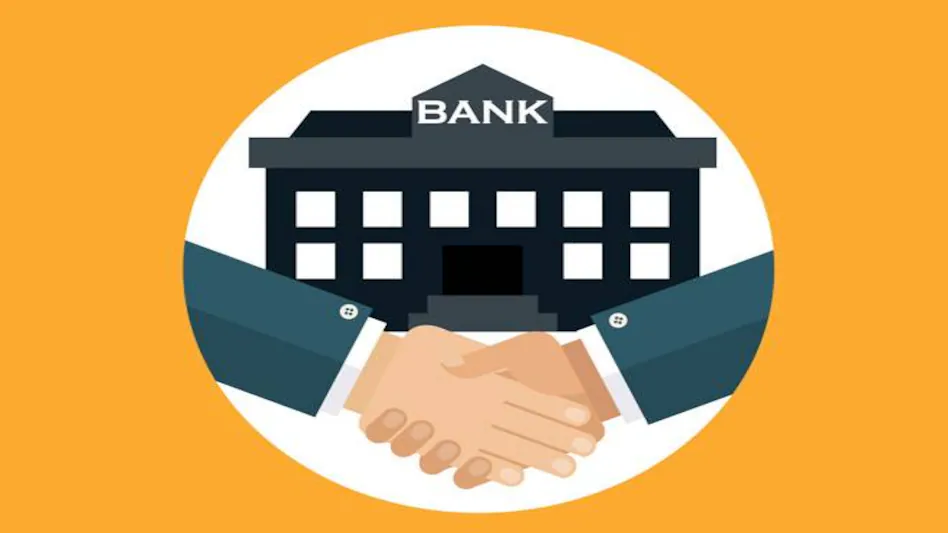

## Скачивание данных

Скачаем данные и импортируем нужные библиотеки

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/sknuSa3xoNBsDw) -o bank-issues-data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3473k  100 3473k    0     0  1445k      0  0:00:02  0:00:02 --:--:-- 3286k


В zip архиве лежат файлы как на Kaggle соревнованиях: train.csv и test.csv, как обычно, а также sampleSubmission.csv с требованиями к отправке

In [ ]:
! unzip -qq bank-issues-data.zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Обработка тренировочных данных

In [ ]:
train_data = pd.read_csv('./bank-issues-data/train.csv')
test_data = pd.read_csv('./bank-issues-data/test.csv')

Цель задачи кредитного скоринга: по информации о клиенте определить кредитный рейтинг (то насколько надеждный человек, вернет он кредит или нет)

Наша задача: к нам (и к другим банкам) приходят клиенты, желая взять кредит. Хотим понять, выберет ли клиент именно наш банк среди всех банков, кто согласился дать кредит

In [ ]:
train_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,0.0,1
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0,1
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,0.0,1
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0,0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0,0


Поля данных:
- **client_id** — Уникальный идентификатор клиента
- **gender** — Пол
- **age** — Возраст (в годах)
- **marital_status** — Семейное положение.
    Возможные значения:
    - UNM : Холост/не замужем
    - DIV : Резведен (а)
    - MAR : Женат/замужем
    - WID : Вдовец, вдова
    - CIV : Гражданский брак
- **job_position** — Работа.
    Возможные значения:
    - SPC : Неруководящий сотрудник - специалист
    - DIR : Руководитель организации
    - HSK : Домохозяйка
    - WOI : Работает на ИП
    - WRK : Неруководящий сотрудник - рабочий
    - ATP : Неруководящий сотрудник - обслуживающий персонал
    - WRP : Работающий пенсионер
    - UMN : Руководитель подразделения
    - NOR : Не работает
    - NS : Пенсионер
    - BIS : Собственный бизнес
    - INP : Индивидуальный предприниматель
- **credit_sum** — Сумма кредита
- **credit_month** — Срок кредитования в месяцах
- **tariff_id** — Номер предлагаемого тарифа (тарифы внутри нашего банка, к сожалению нет подробной инфы об этом)
- **education** — Тип образования.
    Возможные знаяения:
    - SCH : Начальное, среднее
    - PGR : Второе высшее
    - GRD : Высшее
    - UGR : Неполное высшее
    - ACD : Ученая степень
- **living_region** — Регион проживания
- **monthly_income** — Зарплата в месяц
- **credit_count** — Количество кредитов у клиента
- **overdue_credit_count** — Количество просроченных кредитов клиента
- **open_account_flag** — Целевая переменная — выберет клиент наш банк или нет

Отделим целевую переменную от признаков:

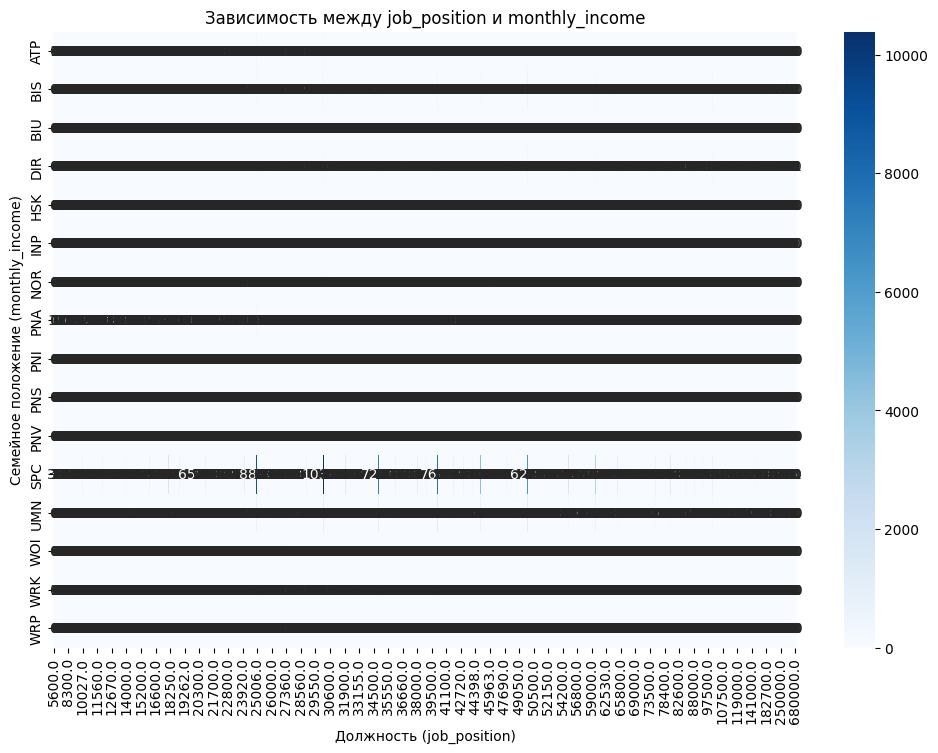

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Создание сводной таблицы
contingency_table = pd.crosstab(train_data['job_position'], train_data['monthly_income'])

# Визуализация сводной таблицы с помощью тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Зависимость между job_position и monthly_income')
plt.xlabel('Должность (job_position)')
plt.ylabel('Семейное положение (monthly_income)')
plt.show()

In [ ]:
y_train = train_data['open_account_flg']
train_data = train_data.drop(columns=['open_account_flg'])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119518 entries, 0 to 119517
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             119518 non-null  int64  
 1   gender                119518 non-null  object 
 2   age                   119518 non-null  int64  
 3   marital_status        119518 non-null  object 
 4   job_position          119518 non-null  object 
 5   credit_sum            119518 non-null  float64
 6   credit_month          119518 non-null  int64  
 7   tariff_id             119518 non-null  float64
 8   score_shk             119518 non-null  float64
 9   education             119518 non-null  object 
 10  living_region         119385 non-null  object 
 11  monthly_income        119518 non-null  float64
 12  credit_count          113032 non-null  float64
 13  overdue_credit_count  113032 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 12.

### Заполнение пропусков

Еще раз выведем то, как выглядят тренировочные данные для удобства

In [ ]:
train_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,0.0
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,0.0
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0


Посмотрим, в каких колонках есть пропуски в тренировочных данных

In [ ]:
train_data.isna().any()

,0
client_id,False
gender,False
age,False
marital_status,False
job_position,False
credit_sum,False
credit_month,False
tariff_id,False
score_shk,False
education,False


Посмотрим также, какие пропуски есть в тестовых данных:

In [ ]:
test_data.isna().any()

,0
client_id,False
gender,False
age,False
marital_status,False
job_position,False
credit_sum,False
credit_month,False
tariff_id,False
score_shk,False
education,False


Видим, что в тестовой части есть пропуски в колонке monthly_income, а в тренировочной части в ней пропусков нет. Нам нужно будет понять, как мы будем заполнять пропуски в этой колонке.

**Внимание**: важно помнить, что иногда в данных бывают пропуски, которые pandas не ловит. Например, когда пропуск в категориальной колонке "job_position", и выражается он тем, что вместо значения стоит пустая строка '' или пробел ' '. Такое pandas не отловит.

**Как можно заполнять пропуски в колонках?**



#### Варианты заполнения пропусков

- Заполнить пропуски некоторой статистикой по данным (среднее/медиана/0/...). Поможет [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) из Sklearn;

    **Вопрос**: почему медиана предпочтительнее среднего?

- Использовать более сложные стратегии. Например, [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) или  [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html);

- Добавить значение "пропуск" на место пропусков. Поможет [MissingIndicator](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator) из Sklearn;
- А иногда вообще бывает так, что из тренировочных данных лучше удалить строки, где много пропусков. Логика такая: если об объекте известно мало, то полезной информации для модели этот объект не несет. Обратите внимание, что из тестовых данных никакие строки удалять нельзя!
- Вообще удалить признак с пропусками. Может быть логично, если пропусков слишком много;

Также если у нас есть пропуски в тестовых данных, мы обязательно должны их заполнить, причем заполнить какими-то статистиками из тренировочной модели. Нельзя брать статистики из тестовой модели и заполнять пропуски ими.

В нашем случае только 4 колонки с пропусками в тестовых данных, которые нам нужно заполнить, но по жизни нужно заботиться о том, чтобы мы могли заполнить любые колонки (чтобы были готовы выбранные статистики для этого)

#### Заполнение пропусков в наших данных

Посмотрим, сколько пропущенных значений в колонках credit_count и overdue_credit_count:

In [ ]:
train_data['credit_count'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 119518 entries, 0 to 119517
Series name: credit_count
Non-Null Count   Dtype  
--------------   -----  
113032 non-null  float64
dtypes: float64(1)
memory usage: 933.9 KB


In [ ]:
np.unique(train_data['credit_count'], return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., nan]),
 array([18219, 31714, 25799, 16707,  9826,  5285,  2760,  1345,   707,
          326,   141,    90,    56,    25,    12,    10,     2,     4,
            1,     3,  6486]))

Заполним пропуск в credit_count медианой:

In [ ]:
# заполнение пропусков статистикой вручную

# median_value_credit_count = np.median(train_data['credit_count'].dropna())
# train_data['credit_count'].fillna(median_value_credit_count)

```Fit()``` используется для "обучения" преобразователя. Он вычисляет статистику, которая будет использоваться в дальнейшем.

```Transform()``` использует статистику полученную во время преобразования ```fit()```

In [ ]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(missing_values=np.nan, strategy='median') # создание экземпляра класса для передачи нужных настроек
simple_imputer.fit(train_data[['credit_count']]) # SimpleImputer обучается на самой колонке
train_data['credit_count'] = simple_imputer.transform(train_data[['credit_count']]) # трансформирует такую колонку

In [ ]:
train_data['credit_count'].isna().any()

np.False_

Заполним пропуск в overdue_credit_count с помощью KNNImputer. Для начала выберем числовые колонки:

In [ ]:
train_data['job_position'].dtype

dtype('O')

In [ ]:
numeric_columns = [column for column in train_data.columns if train_data[column].dtype != 'O']
numeric_columns

['client_id',
 'age',
 'credit_sum',
 'credit_month',
 'tariff_id',
 'score_shk',
 'monthly_income',
 'credit_count',
 'overdue_credit_count']

In [ ]:
len(numeric_columns)

9

Мы можем подавать несколько числовых колонок, но нас лично интересут только преобразование колонки overdue_credit_count, поэтому мы отдельно ее выщипываем из всеобщего массива полученных новых колонок

In [ ]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=2)
knn_imputer.fit(train_data[numeric_columns]) # сюда можно подставить несколько колонок, мы как раз подаем числовые колонки
transformed_overdue_credit_count = knn_imputer.transform(train_data[numeric_columns])[:, 8] # все строки из массива с колонкой 8
train_data['overdue_credit_count'] = transformed_overdue_credit_count

In [ ]:
train_data['overdue_credit_count'].isna().any()

np.False_

Примечание: можно было до этого поработать над категориальными признаками, привести их к числовым и обработать тут, но мы не сделали этого. А еще на client_id не стоит обучать данные, ведь это нехороший признак

Надо ли предварительно скейлить? Можно и делать, и не делать, зависит от наших желаний и наших решений, а также от данных (насколько сильные разрывы)

Также у нас есть monthly_income (нужно самому придумать что с этим можно сделать) и living_region (с ним мы разберемся позже)

**Вот какая у меня идея:** давайте сгруппируем по job_position и возьмем среднее значение по каждой из групп, там где у нас пропуски

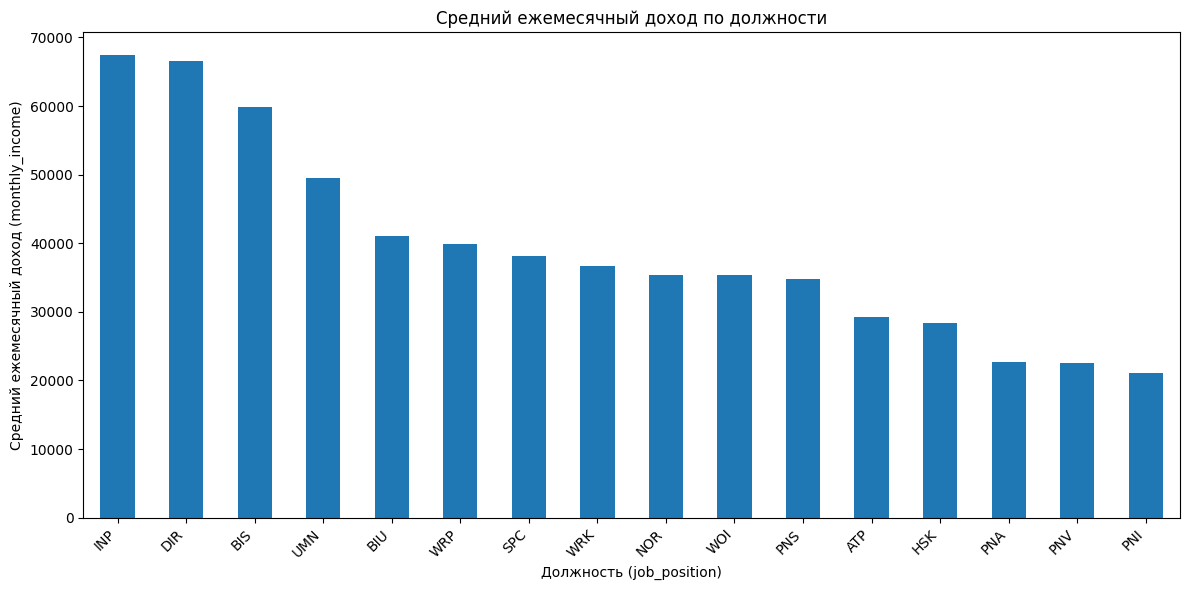

In [ ]:
# Сгруппируйте данные по job_position и вычислите среднее monthly_income
average_income_by_job = train_data.groupby('job_position')['monthly_income'].mean().sort_values(ascending=False)

# Постройте столбчатую диаграмму
plt.figure(figsize=(12, 6))
average_income_by_job.plot(kind='bar')
plt.title('Средний ежемесячный доход по должности')
plt.xlabel('Должность (job_position)')
plt.ylabel('Средний ежемесячный доход (monthly_income)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
test_data['monthly_income'].isna().sum()

np.int64(1)

Так как тут только 1 значение то можно и дропнуть, но в целом это писалось бы так:

In [ ]:
gap_monthly_income = test_data[test_data['monthly_income'].isna()]
gap_monthly_income


,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
4865,124384,F,33,MAR,BIS,13009.0,10,1.6,0.535834,SCH,ПРИМОРСКИЙ КРАЙ,NaN,2.0,0.0


In [ ]:
# Вычислите средний monthly_income по job_position на train_data
# Этот шаг у вас уже сделан, но для ясности повторим
average_income_by_job_train = train_data.groupby('job_position')['monthly_income'].mean()

# Заполнение пропусков в monthly_income в test_data
# Используем average_income_by_job_train для сопоставления по job_position
test_data['monthly_income'] = test_data['monthly_income'].fillna(
    test_data['job_position'].map(average_income_by_job_train)
)

# Проверим, остались ли пропуски в monthly_income в test_data
# После такого заполнения могут остаться пропуски, если какая-то job_position в test_data
# не присутствовала в train_data. Их можно заполнить общим средним или медианой из train_data.
print("Количество пропусков в 'monthly_income' после заполнения:", test_data['monthly_income'].isna().sum())

Количество пропусков в 'monthly_income' после заполнения: 0


In [ ]:
# Заполним оставшиеся пропуски (если есть) общей медианой monthly_income из train_data
median_income_all_jobs_train = train_data['monthly_income'].median()
test_data['monthly_income'].fillna(median_income_all_jobs_train, inplace=True)

print("Количество пропусков в 'monthly_income' после второго этапа заполнения:", test_data['monthly_income'].isna().sum())

Количество пропусков в 'monthly_income' после второго этапа заполнения: 0


/tmp/ipython-input-2371892721.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['monthly_income'].fillna(median_income_all_jobs_train, inplace=True)


Еще если у нас в тестовой выборке строка, где очень много пропущенных значений, можно обработать ее и сразу присудить то, что мы не выдаем кредит, например. И указать это в деплое. Но у нас конечно совсем другая задача

### Обработка категориальных признаков

In [ ]:
train_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,0.0
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,0.0
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0


In [ ]:
categorical_columns = [column for column in train_data.columns if train_data[column].dtype == 'O']
categorical_columns

['gender', 'marital_status', 'job_position', 'education', 'living_region']

Но вот tariff_id тоже категориальная переменная, пусть и представлена численно. Такое нужно добавлять вручную в список

Фанфакт: score_shk – внутренний скор который мы дали клиенту

In [ ]:
categorical_columns = categorical_columns + ['tariff_id']

С living_region мы потом разберемся

In [ ]:
categorical_columns = [x for x in categorical_columns if x != 'living_region']

In [ ]:
np.unique(train_data['marital_status'])

array(['CIV', 'DIV', 'MAR', 'UNM', 'WID'], dtype=object)

#### One-hot кодирование

Pandas лучше не использовать вот почему: если всего 5 вариантов для колонок (['CIV', 'DIV', 'MAR', 'UNM', 'WID']), а в тестовой выборке нет ни одного человека для 'MAR', то такой столбец вовсе не создастся, их будет 4, а это неправильно

Если вдруг получится такое, что пришла тестовая строчка с вариантом, которого не было в тренированных ('MAR' например), то придется дропнуть этот признак

In [ ]:
# dummy_features = pd.get_dummies(train_data['marital_status'])
# dummy_features.head()

One-hot кодирование с помощью OneHotEncoder из Sklearn

In [ ]:
categorical_columns

['gender', 'marital_status', 'job_position', 'education', 'tariff_id']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='if_binary', sparse_output=False) # если колонка бинарная, то по сути не нужно делать 2 колонки
ohe.fit(train_data[categorical_columns])
new_category_columns = ohe.transform(train_data[categorical_columns])

In [ ]:
new_category_columns

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

Создали много-много новых переменных

In [ ]:
ohe.get_feature_names_out()

array(['gender_M', 'marital_status_CIV', 'marital_status_DIV',
       'marital_status_MAR', 'marital_status_UNM', 'marital_status_WID',
       'job_position_ATP', 'job_position_BIS', 'job_position_BIU',
       'job_position_DIR', 'job_position_HSK', 'job_position_INP',
       'job_position_NOR', 'job_position_PNA', 'job_position_PNI',
       'job_position_PNS', 'job_position_PNV', 'job_position_SPC',
       'job_position_UMN', 'job_position_WOI', 'job_position_WRK',
       'job_position_WRP', 'education_ACD', 'education_GRD',
       'education_PGR', 'education_SCH', 'education_UGR', 'tariff_id_1.0',
       'tariff_id_1.1', 'tariff_id_1.16', 'tariff_id_1.17',
       'tariff_id_1.18', 'tariff_id_1.19', 'tariff_id_1.2',
       'tariff_id_1.21', 'tariff_id_1.22', 'tariff_id_1.23',
       'tariff_id_1.24', 'tariff_id_1.25', 'tariff_id_1.26',
       'tariff_id_1.27', 'tariff_id_1.28', 'tariff_id_1.29',
       'tariff_id_1.3', 'tariff_id_1.32', 'tariff_id_1.4',
       'tariff_id_1.41', 'tarif

In [ ]:
# просто переводим то что у нас получилось в датафрейм, задаем названия столбцов. и далее мерджим
new_train_columns = pd.DataFrame(new_category_columns, columns=ohe.get_feature_names_out())
train_data = train_data.drop(columns=categorical_columns)
train_data = pd.concat([train_data, new_train_columns], axis=1) # конкатенация по столбцам axis = 1
train_data.head()

,client_id,age,credit_sum,credit_month,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_M,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,1,25,26389.0,10,0.584105,ОБЛ КУРСКАЯ,35000.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,37,19588.0,12,0.718935,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28,53669.0,18,0.586015,МОСКВА Г,70000.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,34,26349.0,10,0.655703,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,43,11589.0,10,0.271893,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Обработка living_region

In [ ]:
new = np.unique(train_data['living_region'].dropna(), return_counts=True)
print(new)
len(new[0])

(array(['74', '98', 'АДЫГЕЯ РЕСП', 'АЛТАЙСКИЙ', 'АЛТАЙСКИЙ КРАЙ',
       'АМУРСКАЯ ОБЛ', 'АМУРСКАЯ ОБЛАСТЬ', 'АО НЕНЕЦКИЙ',
       'АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю', 'АО ЯМАЛО-НЕНЕЦКИЙ',
       'АОБЛ ЕВРЕЙСКАЯ', 'АРХАНГЕЛЬСКАЯ', 'АРХАНГЕЛЬСКАЯ ОБЛ',
       'АРХАНГЕЛЬСКАЯ ОБЛАСТЬ', 'АСТРАХАНСКАЯ', 'АСТРАХАНСКАЯ ОБЛ',
       'АСТРАХАНСКАЯ ОБЛАСТЬ', 'БАШКОРТОСТАН', 'БАШКОРТОСТАН РЕСП',
       'БЕЛГОРОДСКАЯ ОБЛ', 'БЕЛГОРОДСКАЯ ОБЛАСТЬ', 'БРЯНСКАЯ ОБЛ',
       'БРЯНСКАЯ ОБЛАСТЬ', 'БРЯНСКИЙ', 'БУРЯТИЯ', 'БУРЯТИЯ РЕСП',
       'ВЛАДИМИРСКАЯ ОБЛ', 'ВЛАДИМИРСКАЯ ОБЛАСТЬ', 'ВОЛГОГРАДСКАЯ ОБЛ',
       'ВОЛГОГРАДСКАЯ ОБЛАСТЬ', 'ВОЛОГОДСКАЯ', 'ВОЛОГОДСКАЯ ОБЛ',
       'ВОЛОГОДСКАЯ ОБЛ.', 'ВОЛОГОДСКАЯ ОБЛАСТЬ', 'ВОРОНЕЖСКАЯ ОБЛ',
       'ВОРОНЕЖСКАЯ ОБЛАСТЬ', 'Г МОСКВА', 'Г. МОСКВА',
       'Г. САНКТ-ПЕТЕРБУРГ', 'Г.МОСКВА', 'ГОРЬКОВСКАЯ ОБЛ',
       'ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н', 'ДАГЕСТАН РЕСП', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
       'ЕВРЕЙСКАЯ АОБЛ', 'ЗАБАЙКАЛЬСКИЙ КРАЙ', 'ИВАНОВСКАЯ ОБЛ',
       'ИВАНО

285

In [ ]:
living_region_counts = train_data['living_region'].value_counts()
frequent_regions = living_region_counts[living_region_counts > 100].index.tolist()
print(frequent_regions)
len(frequent_regions)

['ОБЛ МОСКОВСКАЯ', 'КРАСНОДАРСКИЙ КРАЙ', 'САНКТ-ПЕТЕРБУРГ', 'МОСКВА', 'ТАТАРСТАН РЕСП', 'РЕСП БАШКОРТОСТАН', 'ОБЛ ИРКУТСКАЯ', 'СВЕРДЛОВСКАЯ ОБЛ', 'МОСКВА Г', 'ОБЛ НИЖЕГОРОДСКАЯ', 'ОБЛ ЛЕНИНГРАДСКАЯ', 'РОСТОВСКАЯ ОБЛ', 'КРАСНОЯРСКИЙ КРАЙ', 'ЧЕЛЯБИНСКАЯ ОБЛ', 'ОБЛ САМАРСКАЯ', 'ОБЛ КЕМЕРОВСКАЯ', 'ПЕРМСКИЙ КРАЙ', 'САНКТ-ПЕТЕРБУРГ Г', 'КРАЙ СТАВРОПОЛЬСКИЙ', 'ОБЛ ВОЛОГОДСКАЯ', 'ОБЛ АСТРАХАНСКАЯ', 'ОБЛ ВОЛГОГРАДСКАЯ', 'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА', 'РЕСПУБЛИКА ТАТАРСТАН', 'ОБЛ НОВОСИБИРСКАЯ', 'СВЕРДЛОВСКАЯ ОБЛАСТЬ', 'СТАВРОПОЛЬСКИЙ КРАЙ', 'ЯМАЛО-НЕНЕЦКИЙ АО', 'ОБЛ АРХАНГЕЛЬСКАЯ', 'ОБЛ ВОРОНЕЖСКАЯ', 'ЧЕЛЯБИНСКАЯ ОБЛАСТЬ', 'ОБЛ ВЛАДИМИРСКАЯ', 'ХАБАРОВСКИЙ КРАЙ', 'ХАНТЫ-МАНСИЙСКИЙ АО', 'САРАТОВСКАЯ ОБЛ', 'РЕСП. БАШКОРТОСТАН', 'САМАРСКАЯ ОБЛ', 'ОБЛ МУРМАНСКАЯ', 'ОБЛ КУРГАНСКАЯ', 'ОБЛ СВЕРДЛОВСКАЯ', 'РЕСП КОМИ', 'САХА /ЯКУТИЯ/ РЕСП', 'КРАЙ ЗАБАЙКАЛЬСКИЙ', 'ПРИМОРСКИЙ КРАЙ', 'РЕСП БУРЯТИЯ', 'ТЮМЕНСКАЯ ОБЛ', 'ОБЛ КУРСКАЯ', 'ОБЛ КАЛУЖСКАЯ', 'РОСТОВСКАЯ ОБЛАСТЬ', 'ОБЛ ИВАНОВСКАЯ', 'ТВЕРСК

125

Какие проблемы тут есть или могут возникнуть:

- Один и тот же регион написан по-разному;
- Есть регионы, которые встречаются очень редко;
- Возможны два типа ситуаций:
    - Какой-то регион есть в тренировочных данных, но его нет в тестовых;
    - Какой-то регион есть в тестовых данных, но его нет в тренировочных.

Также из этого признака можно создать новые признаки:
- какие?


Видим, что очень много значений, поэтому one-hot encoding было бы нецелесообразно делать. Также есть много повторов ('Г МОСКВА', 'Г. МОСКВА', 'Г.МОСКВА'), которые нам нужно обработать

Также этот признак очень плох: например 10 человек из одного региона (например Тыва), когда у нас миллионы строк. Если нейросеть будет полагаться на этот признак, например решающее дерево, то это плохо, так как на основе 10 человек нельзя делать выводы при таком объеме данных. Это приведет к переобучению

В библиотеке sklearn есть функции, которые помогают находить признаки с маленькой дисперсией, с низкой вариабельностью значений. Такие признаки лучше удалять!



Другое решение: если у региона количество людей больше заданного порога (100 например), а остальные регионы мы схлопываем в один признак "Другое"

**Задание**: обработайте признак living_region. Не забудьте, что в тестовых данных вам нужно будет обработать этот признак в той же манере, что и в тренировочных данных.

### Создание новых признаков

#### Ручное создание новых признаков

Можно найти статистику по среднему заработку внутри регионов и уже так заполнить mothly_income. Можно подсчитать отношение ежемесячной выплаты к зарплате, то есть какой процент от своей зарплаты человек готов отдавать

In [ ]:
train_data.head()

,client_id,age,credit_sum,credit_month,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_M,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,1,25,26389.0,10,0.584105,ОБЛ КУРСКАЯ,35000.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,37,19588.0,12,0.718935,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28,53669.0,18,0.586015,МОСКВА Г,70000.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,34,26349.0,10,0.655703,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,43,11589.0,10,0.271893,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Часто на основе имеющихся признаков можно создавать новые. Какие новые признаки приходят на ум для нашего датасета?

#### Автоматическое создание новых признаков

Помогут [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) из sklearn

Есть фичи x, y, z, и мы задаем degree = 2, то строятся новые фичи x^2, y^2, z^2, xy, и тд., то есть все возможные полиномы. Далее можно отсеивать признаки, какие-то помогают, а какие-то нет (это надо выяснить)

Берется простая модель обучения (лог регрессия, лин регрессия), обучаем на всех фичах, смотрим на те фичи, на которые модель обратила внимание, оставляем топ таких фичей. А потом берем что-то более сложное (градиентный бустинг, дерево решений, случайный лес и т.д.).

Например, для логистической регресии у нас получается, что скор это сумма наших полиномов с некоторыми коэффициентами, и так мы можем понять значимость переменнных, посмотрев на модуль коэффициента (но нужно помнить что для линейных моделей надо стандартизовать переменные).

У random forest (и других моделей с деревьями) есть feature_importances, который выдает относительную важность фичей.

В линейных моделей вадна суперпозиция признаков, и иногда группа признаков, которая плохо коррелирует с целей переменной может давать сумарно хороший результат. Так что нужно это помнить при применеии корреляции и выбирать по модели в том числе

### Фильтрация признаков

Помогут [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector), [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) и другие классы из модуля [feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) sklearn.

SelectFromModel как раз помогает выбирать признаки на основе важности

## Обработка тестовых данных

In [ ]:
test_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,119519,F,24,MAR,SPC,28429.0,18,1.10,0.593836,GRD,ОБЛ ИРКУТСКАЯ,33000.0,3.0,0.0
1,119520,M,25,UNM,SPC,15997.0,10,1.60,0.615015,SCH,УЛЬЯНОВСКАЯ ОБЛ,35000.0,2.0,0.0
2,119521,M,25,UNM,SPC,11043.0,10,1.16,0.666758,SCH,РЕСП БАШКОРТОСТАН,25000.0,3.0,0.0
3,119522,F,34,MAR,SPC,14617.0,10,1.40,0.447745,GRD,ПЕНЗЕНСКАЯ ОБЛ,15000.0,2.0,0.0
4,119523,M,33,MAR,SPC,38147.0,12,1.60,0.706974,UGR,ОБЛ МОСКОВСКАЯ,55000.0,1.0,0.0


Заполнение пропусков в данных:

In [ ]:
test_data['credit_count'] = simple_imputer.transform(test_data[['credit_count']])
transformed_test_data = knn_imputer.transform(test_data[numeric_columns])[:, 8]
test_data['overdue_credit_count'] = transformed_test_data

Вспомним теперь, что в тестовых данных также есть пропуск в колонке monthly_income.

**Задание**: заполните пропуск в monthly_income в тестовых данных

Обработка категориальных признаков:

In [ ]:
new_category_columns_test = ohe.transform(test_data[categorical_columns])
new_test_columns = pd.DataFrame(new_category_columns_test, columns=ohe.get_feature_names_out())
test_data = test_data.drop(columns=categorical_columns)
test_data = pd.concat([test_data, new_test_columns], axis=1)
test_data.head()

,client_id,age,credit_sum,credit_month,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_M,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,119519,24,28429.0,18,0.593836,ОБЛ ИРКУТСКАЯ,33000.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,119520,25,15997.0,10,0.615015,УЛЬЯНОВСКАЯ ОБЛ,35000.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,119521,25,11043.0,10,0.666758,РЕСП БАШКОРТОСТАН,25000.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,119522,34,14617.0,10,0.447745,ПЕНЗЕНСКАЯ ОБЛ,15000.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,119523,33,38147.0,12,0.706974,ОБЛ МОСКОВСКАЯ,55000.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


И еще остается отдельный признак living_region.

**Задание**: предобработайте признак living_region

## Обучение и подбор параметров модели

**Задание**: обучите модель машинного обучения на тренировочных данных и подберите гиперпараметры.

Вопрос: когда нужно делить данные на train/val? До или после предобработки признаков тренировочного датасета?

Обратите внимание, что метрика качества в [контесте на Kaggle](https://www.kaggle.com/competitions/bank-issues-042022/leaderboard) для этой задачи — ROC AUC

## Получение предсказаний на тестовых данных

**Задание**: получите предсказания модели на тестовых данных test_data. Полученное предсказание отправьте в [контест на Kaggle](https://www.kaggle.com/competitions/bank-issues-042022/leaderboard)